In [1]:
import tensorflow as tf
from tensorflow import keras

# FID Calculation

inc_model = keras.applications.InceptionV3(include_top=False, pooling='avg', input_shape=(150,150,3))


# scale an array of images to a new size
def scale_images(images, new_shape):
    images_list = list()
    for image in images:
        # resize with nearest neighbor interpolation
        new_image = np.resize(image, new_shape)
        # store
        images_list.append(new_image)
    return np.asarray(images_list)

# calculate frechet inception distance
def calculate_fid(model, images1, images2):
    # preprocessing
    images1 = images1.astype('float32')
    images2 = images2.astype('float32')
    # resize images
    images1 = scale_images(images1, (150,150,3))
    images2 = scale_images(images2, (150,150,3))

    images1 = keras.applications.inception_v3.preprocess_input(images1)
    images2 = keras.applications.inception_v3.preprocess_input(images2)
    # calculate activations
    act1 = model.predict(images1)
    act2 = model.predict(images2)
    # calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False, dtype=np.csingle)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False, dtype=np.csingle)
    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = np.sqrt(sigma1*sigma2)
    # check and correct imaginary numbers from sqrt
    covmean = np.real(covmean)
    # calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return np.real(fid)

# define two fake collections of images
# images1 = np.random.randint(0, 255, 10*32*32*3)
# images1 = images1.reshape((10,32,32,3))
# images2 = np.random.randint(0, 255, 10*32*32*3)
# images2 = images2.reshape((10,32,32,3))

# print(calculate_fid(model, images1, images2))
# print(calculate_fid(model, images1, images1))
# print(calculate_fid(model, images2, images2))

2024-06-20 14:51:39.648362: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-20 14:51:40.172311: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-06-20 14:51:40.830452: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-20 14:51:40.830751: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. 

In [2]:
import os
import math
from abc import abstractmethod

from PIL import Image
import requests
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [3]:
def getTimeEmbedding(t, dim_time=6):
    x = torch.arange(1, 1 + dim_time//2).to(t.device)
    x = 2*x/dim_time
    sin_emb = torch.sin(t[:,None]/10000*(x[None,:]))
    cos_emb = torch.cos(t[:,None]/10000*(x[None,:]))
    out = torch.zeros(t.shape[0],dim_time).to(t.device)
    even = 2*torch.arange(dim_time//2)
    out[:,even] = sin_emb
    out[:,even+1] = cos_emb
    return out

# def getTimeEmbedding(t, dim_time) :
#     out = torch.zeros((t.shape[0], dim_time)).to(t.device)
#     i = torch.arange(dim_time//2).to(t.device)
#     even = 2*torch.arange(dim_time//2).to(t.device)
#     out[:,even] = torch.sin(t[:,None] / 10000**(2*i[None,:]/dim_time))
#     out[:,even+1] = torch.cos(t[:,None] / 10000**(2*i[None,:]/dim_time))
#     return out

In [4]:
class fwdNet(nn.Module) :
    def __init__(self, in_dim, out_dim=-1, dim_time=-1) :
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim if out_dim!=-1 else in_dim
        self.dim_time = dim_time if dim_time!=-1 else in_dim
        self.fwd_conv = nn.Sequential( 
            nn.Conv1d(1, 8, kernel_size=2), 
            nn.Tanh(),
            nn.Conv1d(8, 8, kernel_size=2), 
            nn.Tanh(),
            nn.Conv1d(8, 8, kernel_size=2), 
            nn.Flatten(),
            nn.Linear(24,16),
            nn.Tanh(),
            nn.Linear(16,2),
        )
    def forward(self, x, t) :
        '''
        x.shape = (b,1,2)
        t.shape = (b,)
        '''
        time_emb = getTimeEmbedding(t, self.dim_time)[:,None,:] # (b,1,dim_time)
        input = torch.cat((x, time_emb), dim=-1) # (b, 2+dim_time)
        return self.fwd_conv(input)[:,None,:] # (b,1,2)

In [5]:
a = fwdNet(2, dim_time=4)
a(torch.randn(100,1,2), torch.randn(100)).shape

torch.Size([100, 1, 2])

In [6]:
# beta schedule
def linear_beta_schedule(timesteps):
    scale = 1000 / timesteps
    beta_start = scale * 0.0001
    beta_end = scale * 0.02
    return torch.linspace(beta_start, beta_end, timesteps, dtype=torch.float64)

def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule
    as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps, dtype=torch.float64)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * math.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0, 0.999)

In [7]:
class GaussianDiffusion:
    def __init__(
        self,
        timesteps=1000,
        beta_schedule='linear'
    ):
        self.timesteps = timesteps
        
        if beta_schedule == 'linear':
            betas = linear_beta_schedule(timesteps)
        elif beta_schedule == 'cosine':
            betas = cosine_beta_schedule(timesteps)
        else:
            raise ValueError(f'unknown beta schedule {beta_schedule}')
        self.betas = betas
            
        self.alphas = 1. - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.)
        
        # calculations for diffusion q(x_t | x_{t-1}) and others
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)
        self.log_one_minus_alphas_cumprod = torch.log(1.0 - self.alphas_cumprod)
        self.sqrt_recip_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod)
        self.sqrt_recipm1_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod - 1)
        
        # calculations for posterior q(x_{t-1} | x_t, x_0)
        self.posterior_variance = (
            self.betas * (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )
        # below: log calculation clipped because the posterior variance is 0 at the beginning
        # of the diffusion chain
        #self.posterior_log_variance_clipped = torch.log(self.posterior_variance.clamp(min =1e-20))
        self.posterior_log_variance_clipped = torch.log(
            torch.cat([self.posterior_variance[1:2], self.posterior_variance[1:]])
        )
        
        self.posterior_mean_coef1 = (
            self.betas * torch.sqrt(self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )
        self.posterior_mean_coef2 = (
            (1.0 - self.alphas_cumprod_prev)
            * torch.sqrt(self.alphas)
            / (1.0 - self.alphas_cumprod)
        )
        
        # get the param of given timestep t
    def _extract(self, a, t, x_shape):
        batch_size = t.shape[0]
        out = a.to(t.device).gather(0, t).float()
        out = out.reshape(batch_size, *((1,) * (len(x_shape) - 1)))
        return out
    
    # forward diffusion (using the nice property): q(x_t | x_0)
    def q_sample(self, x_start, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x_start)

        sqrt_alphas_cumprod_t = self._extract(self.sqrt_alphas_cumprod, t, x_start.shape)
        sqrt_one_minus_alphas_cumprod_t = self._extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape)

        return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise
    
    # Get the mean and variance of q(x_t | x_0).
    def q_mean_variance(self, x_start, t):
        mean = self._extract(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start
        variance = self._extract(1.0 - self.alphas_cumprod, t, x_start.shape)
        log_variance = self._extract(self.log_one_minus_alphas_cumprod, t, x_start.shape)
        return mean, variance, log_variance
    
    # Compute the mean and variance of the diffusion posterior: q(x_{t-1} | x_t, x_0)
    def q_posterior_mean_variance(self, x_start, x_t, t):
        posterior_mean = (
            self._extract(self.posterior_mean_coef1, t, x_t.shape) * x_start
            + self._extract(self.posterior_mean_coef2, t, x_t.shape) * x_t
        )
        posterior_variance = self._extract(self.posterior_variance, t, x_t.shape)
        posterior_log_variance_clipped = self._extract(self.posterior_log_variance_clipped, t, x_t.shape)
        return posterior_mean, posterior_variance, posterior_log_variance_clipped
    
    # compute x_0 from x_t and pred noise: the reverse of `q_sample`
    def predict_start_from_noise(self, x_t, t, noise):
        return (
            self._extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t -
            self._extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape) * noise
        )
    
    # compute predicted mean and variance of p(x_{t-1} | x_t)
    def p_mean_variance(self, model, x_t, t, clip_denoised=True):
        # predict noise using model
        # print(x_t.shape, t.shape); raise
        pred_noise = model(x_t, t)
        # get the predicted x_0: different from the algorithm2 in the paper
        x_recon = self.predict_start_from_noise(x_t, t, pred_noise)
        if clip_denoised:
            x_recon = torch.clamp(x_recon, min=-1., max=1.)
        model_mean, posterior_variance, posterior_log_variance = \
                    self.q_posterior_mean_variance(x_recon, x_t, t)
        return model_mean, posterior_variance, posterior_log_variance
    
    # denoise_step: sample x_{t-1} from x_t and pred_noise
    @torch.no_grad()
    def p_sample(self, model, x_t, t, clip_denoised=True, fast_samp=False):
        # predict mean and variance
        model_mean, _, model_log_variance = self.p_mean_variance(model, x_t, t,
                                                    clip_denoised=clip_denoised)
        noise = torch.randn_like(x_t)
        # no noise when t == 0
        nonzero_mask = ((t != 0).float().view(-1, *([1] * (len(x_t.shape) - 1))))
        if fast_samp : nonzero_mask = torch.zeros_like(nonzero_mask)
        # compute x_{t-1}
        pred_img = model_mean + nonzero_mask * (0.5 * model_log_variance).exp() * noise
        return pred_img
    
    # denoise: reverse diffusion
    @torch.no_grad()
    def p_sample_loop(self, model, shape, fast_samp=False):
        batch_size = shape[0]
        device = next(model.parameters()).device
        # start from pure noise (for each example in the batch)
        img = torch.randn(shape, device=device)
        imgs = []
        for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
            img = self.p_sample(model, img, torch.full((batch_size,), i, device=device, dtype=torch.long), False, fast_samp)
            imgs.append(img.cpu().numpy())
        return imgs
    
    # sample new images
    @torch.no_grad()
    def sample(self, model, batch_size=8, size=2, fast_samp=False):
        # return self.p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))
        return self.p_sample_loop(model, shape=(batch_size, 1, size), fast_samp=fast_samp)
    
    # use ddim to sample
    @torch.no_grad()
    def ddim_sample(
        self,
        model,
        size,
        batch_size=8,
        # channels=3,
        ddim_timesteps=50,
        ddim_discr_method="uniform",
        ddim_eta=0.0,
        clip_denoised=False):
        # make ddim timestep sequence
        if ddim_discr_method == 'uniform':
            c = self.timesteps // ddim_timesteps
            ddim_timestep_seq = np.asarray(list(range(0, self.timesteps, c)))
        elif ddim_discr_method == 'quad':
            ddim_timestep_seq = (
                (np.linspace(0, np.sqrt(self.timesteps * .8), ddim_timesteps)) ** 2
            ).astype(int)
        else:
            raise NotImplementedError(f'There is no ddim discretization method called "{ddim_discr_method}"')
        # add one to get the final alpha values right (the ones from first scale to data during sampling)
        ddim_timestep_seq = ddim_timestep_seq + 1
        # previous sequence
        ddim_timestep_prev_seq = np.append(np.array([0]), ddim_timestep_seq[:-1])
        
        device = next(model.parameters()).device
        # start from pure noise (for each example in the batch)
        # sample_img = torch.randn((batch_size, channels, image_size, image_size), device=device)
        sample_img = torch.randn((batch_size, 1, size), device=device)
        original_imgs = sample_img.clone()
        for i in tqdm(reversed(range(0, ddim_timesteps)), desc='sampling loop time step', total=ddim_timesteps):
            t = torch.full((batch_size,), ddim_timestep_seq[i], device=device, dtype=torch.long)
            prev_t = torch.full((batch_size,), ddim_timestep_prev_seq[i], device=device, dtype=torch.long)
            
            # 1. get current and previous alpha_cumprod
            alpha_cumprod_t = self._extract(self.alphas_cumprod, t, sample_img.shape)
            alpha_cumprod_t_prev = self._extract(self.alphas_cumprod, prev_t, sample_img.shape)
    
            # 2. predict noise using model
            pred_noise = model(sample_img, t)
            
            # 3. get the predicted x_0
            pred_x0 = (sample_img - torch.sqrt((1. - alpha_cumprod_t)) * pred_noise) / torch.sqrt(alpha_cumprod_t)
            if clip_denoised:
                pred_x0 = torch.clamp(pred_x0, min=-1., max=1.)
            
            # 4. compute variance: "sigma_t(η)" -> see formula (16)
            # σ_t = sqrt((1 − α_t−1)/(1 − α_t)) * sqrt(1 − α_t/α_t−1)
            sigmas_t = ddim_eta * torch.sqrt(
                (1 - alpha_cumprod_t_prev) / (1 - alpha_cumprod_t) * (1 - alpha_cumprod_t / alpha_cumprod_t_prev))
            
            # 5. compute "direction pointing to x_t" of formula (12)
            pred_dir_xt = torch.sqrt(1 - alpha_cumprod_t_prev - sigmas_t**2) * pred_noise
            
            # 6. compute x_{t-1} of formula (12)
            x_prev = torch.sqrt(alpha_cumprod_t_prev) * pred_x0 + pred_dir_xt + sigmas_t * torch.randn_like(sample_img)

            sample_img = x_prev
            
        return original_imgs, sample_img.cpu().numpy()
    
    # compute train losses
    def train_losses(self, model, x_start, t):
        # generate random noise
        noise = torch.randn_like(x_start)
        # get x_t
        x_noisy = self.q_sample(x_start, t, noise=noise)
        predicted_noise = model(x_noisy, t)
        loss = F.mse_loss(noise, predicted_noise)
        return loss

## Two Concentric Circles

In [8]:
theta1 = 2*torch.pi*torch.randn((10000,))
theta2 = 2*torch.pi*torch.randn((10000,))
R1, R2 = 3, 8
X1 =  R1 * torch.cos(theta1)
X2 =  R2 * torch.cos(theta2)
Y1 =  R1 * torch.sin(theta1)
Y2 =  R2 * torch.sin(theta2)
data1 = [(x,y) for x,y in zip(X1,Y1)]
data2 = [(x,y) for x,y in zip(X2,Y2)]
data = data1 + data2

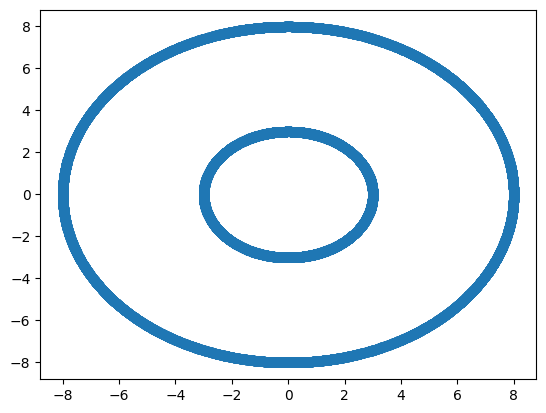

In [9]:
plt.scatter([i[0] for i in data], [i[1] for i in data])

In [10]:
class circle_dataset(torch.utils.data.Dataset) :
    def __init__(self, arr, transforms=None, subset=0) :
        self.arr = arr
        self.transforms = transforms
        if subset>0 : self.arr = self.arr[:subset]
    def __len__(self) :
        return len(self.arr)
    def __getitem__(self, idx) :
        Data = self.arr[idx]
        if self.transforms :
            Data = self.transforms(Data)
        return torch.tensor(Data).unsqueeze(0)


In [11]:
# batch_size = 256
timesteps = 1000

# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5], std=[0.5])
# ])

dataset = circle_dataset(data)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset), shuffle=False)

# define model and diffusion
device = "cuda:1" if torch.cuda.is_available() else "cpu"
print(f'{device=}')
model = fwdNet(2, dim_time=4)
model.to(device)

gaussian_diffusion = GaussianDiffusion(timesteps=timesteps)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

device='cuda:1'


In [12]:
# train
epochs = 4000
losslog = []

for epoch in tqdm(range(epochs)):
    for step, (points) in enumerate(train_loader):
        
        batch_size = points.shape[0]
        points = points.to(device)
        
        # sample t uniformally for every example in the batch
        t = torch.randint(0, timesteps, (batch_size,), device=device).long()
        
        loss = gaussian_diffusion.train_losses(model, points, t)
        with torch.no_grad() : losslog.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if epoch%300==0 : 
        tqdm.write(f"Epoch {epoch} Step {step} Loss: {loss.item()}")
    # if epoch==2000 : 
    #     optimizer.param_groups[0]['lr'] /= 10

optimizer.param_groups[0]['lr'] /= 10
for epoch in tqdm(range(1600)):
    for step, (points) in enumerate(train_loader):
        
        batch_size = points.shape[0]
        points = points.to(device)
        
        # sample t uniformally for every example in the batch
        t = torch.randint(0, timesteps, (batch_size,), device=device).long()
        
        loss = gaussian_diffusion.train_losses(model, points, t)
        with torch.no_grad() : losslog.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if epoch%300==0 : 
        tqdm.write(f"Epoch {epoch} Step {step} Loss: {loss.item()}")

  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch 0 Step 0 Loss: 1.0546928644180298
Epoch 300 Step 0 Loss: 0.7124626636505127
Epoch 600 Step 0 Loss: 0.7092675566673279
Epoch 900 Step 0 Loss: 0.7021978497505188
Epoch 1200 Step 0 Loss: 0.7092709541320801
Epoch 1500 Step 0 Loss: 0.6891290545463562
Epoch 1800 Step 0 Loss: 0.6801989674568176
Epoch 2100 Step 0 Loss: 0.578336775302887
Epoch 2400 Step 0 Loss: 0.5604191422462463
Epoch 2700 Step 0 Loss: 0.5561325550079346
Epoch 3000 Step 0 Loss: 0.5543172955513
Epoch 3300 Step 0 Loss: 0.5478070378303528
Epoch 3600 Step 0 Loss: 0.5354844927787781
Epoch 3900 Step 0 Loss: 0.5443459749221802


  0%|          | 0/1600 [00:00<?, ?it/s]

Epoch 0 Step 0 Loss: 0.5397385358810425
Epoch 300 Step 0 Loss: 0.5431327819824219
Epoch 600 Step 0 Loss: 0.5363768935203552
Epoch 900 Step 0 Loss: 0.5461656451225281
Epoch 1200 Step 0 Loss: 0.5425601601600647
Epoch 1500 Step 0 Loss: 0.5270442366600037


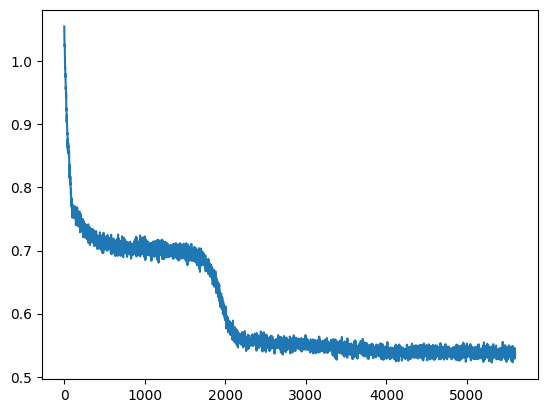

In [13]:
plt.plot(losslog)

In [14]:
generated_images = gaussian_diffusion.sample(model, batch_size=500, size=2, fast_samp=False)

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

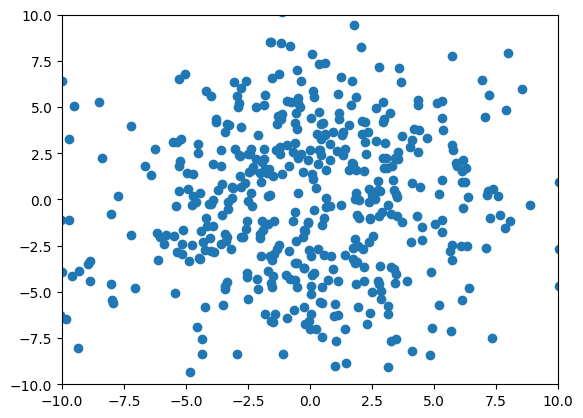

In [15]:
temp = generated_images[-1]
plt.scatter(x=temp[:,0,0], y=temp[:,0,1])
# plt.scatter([i[0] for i in data], [i[1] for i in data])
plt.xlim((-10,10))
plt.ylim((-10,10));

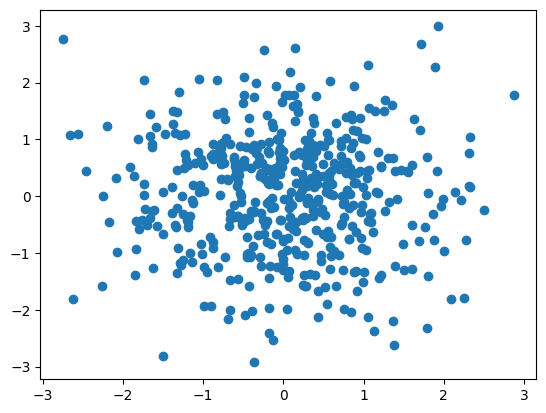

In [ ]:
temp = generated_images[0]
plt.scatter(x=temp[:,0,0], y=temp[:,0,1])

sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

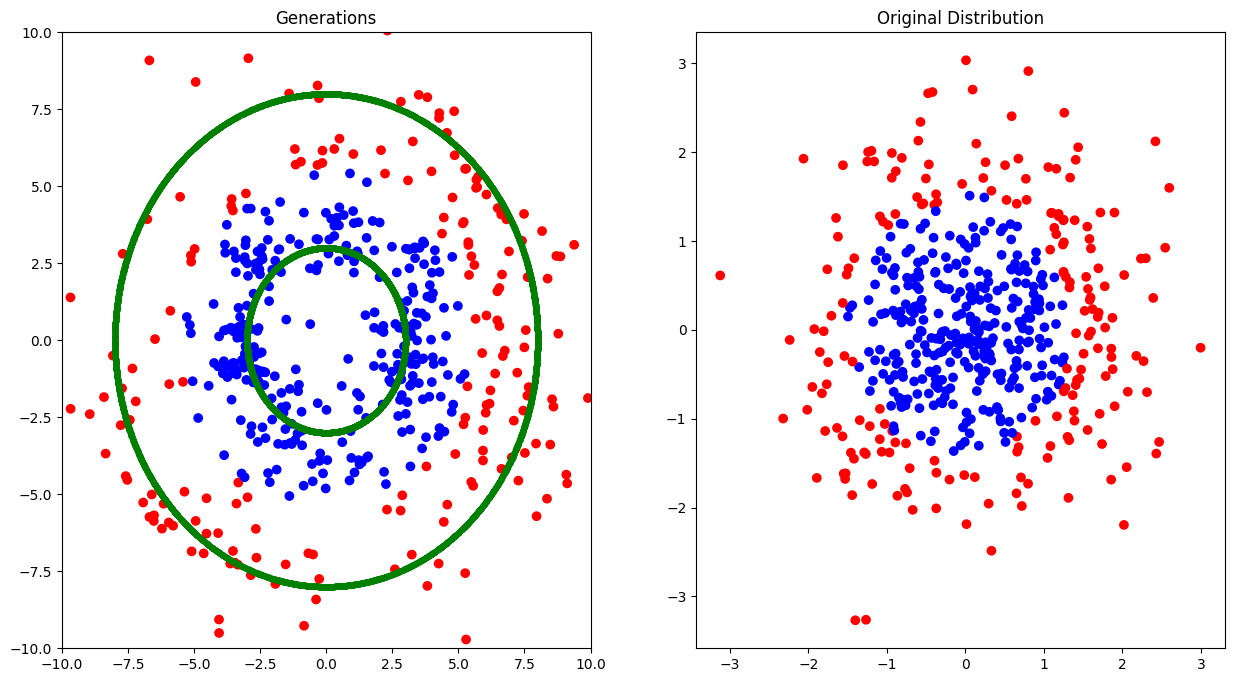

In [ ]:
original_points, creations = gaussian_diffusion.ddim_sample(model, batch_size=500, size=2)
original_points = original_points.squeeze().cpu()
creations = creations.squeeze()
colors = ['red' if x**2 + y**2 > 5.5**2 else 'blue' for (x,y) in creations]

plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.title('Generations')
plt.scatter(x=[i[0] for i in creations], y=[i[1] for i in creations], c=colors)
plt.scatter([i[0] for i in data], [i[1] for i in data], c='green', marker='.')
plt.xlim(-10,10)
plt.ylim(-10,10);
plt.subplot(1,2,2)
plt.title('Original Distribution')
plt.scatter(x=[i[0] for i in original_points], y=[i[1] for i in original_points], c=colors)

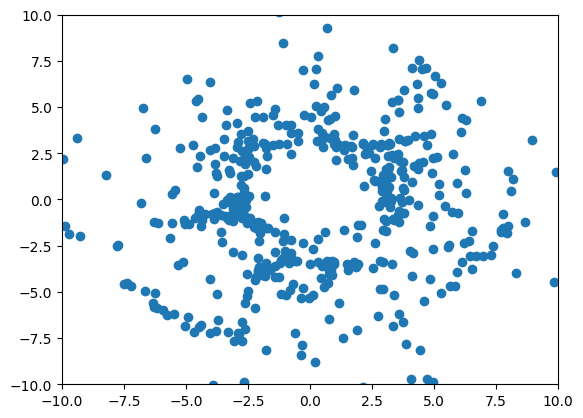

In [ ]:
plt.scatter(x=[i[0] for i in creations], y=[i[1] for i in creations])
plt.xlim(-10,10)
plt.ylim(-10,10);

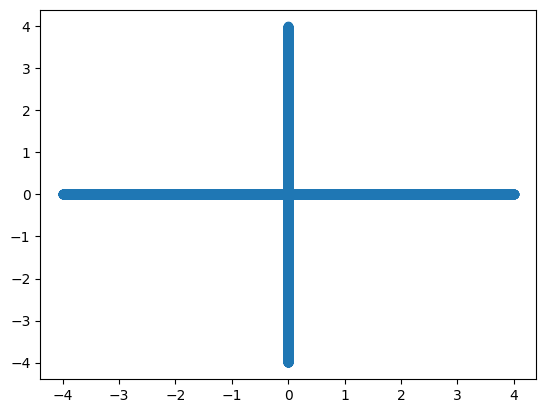

In [ ]:
num_points = 10000
X1 = [0]*num_points
Y1 = 8*(torch.rand(num_points) - 0.5)
X2 = 8*(torch.rand(num_points) - 0.5)
Y2 = [0]*num_points
data1 = [(x,y) for x,y in zip(X1,Y1)]
data2 = [(x,y) for x,y in zip(X2,Y2)]
cross_data = data1 + data2

plt.scatter([i[0] for i in cross_data], [i[1] for i in cross_data])

In [ ]:
class cross_dataset(torch.utils.data.Dataset) :
    def __init__(self, arr, transforms=None, subset=0) :
        self.arr = arr
        self.transforms = transforms
        if subset>0 : self.arr = self.arr[:subset]
    def __len__(self) :
        return len(self.arr)
    def __getitem__(self, idx) :
        Data = self.arr[idx]
        if self.transforms :
            Data = self.transforms(Data)
        return torch.tensor(Data).unsqueeze(0)


In [ ]:
# batch_size = 256
timesteps = 1000

# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5], std=[0.5])
# ])

dataset = cross_dataset(cross_data)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset), shuffle=False)

# define model and diffusion
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f'{device=}')
model = fwdNet(2, dim_time=4)
model.to(device)

gaussian_diffusion = GaussianDiffusion(timesteps=timesteps)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

device='cuda:0'


In [ ]:
# train
epochs = 4000
losslog = []

for epoch in tqdm(range(epochs)):
    for step, (points) in enumerate(train_loader):
        
        batch_size = points.shape[0]
        points = points.to(device)
        
        # sample t uniformally for every example in the batch
        t = torch.randint(0, timesteps, (batch_size,), device=device).long()
        
        loss = gaussian_diffusion.train_losses(model, points, t)
        with torch.no_grad() : losslog.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if epoch%300==0 : 
        tqdm.write(f"Epoch {epoch} Step {step} Loss: {loss.item()}")
    # if epoch==2000 : 
    #     optimizer.param_groups[0]['lr'] /= 10

optimizer.param_groups[0]['lr'] /= 10
for epoch in tqdm(range(1600)):
    for step, (points) in enumerate(train_loader):
        
        batch_size = points.shape[0]
        points = points.to(device)
        
        # sample t uniformally for every example in the batch
        t = torch.randint(0, timesteps, (batch_size,), device=device).long()
        
        loss = gaussian_diffusion.train_losses(model, points, t)
        with torch.no_grad() : losslog.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if epoch%300==0 : 
        tqdm.write(f"Epoch {epoch} Step {step} Loss: {loss.item()}")

  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch 0 Step 0 Loss: 1.0242773294448853
Epoch 300 Step 0 Loss: 0.46529901027679443
Epoch 600 Step 0 Loss: 0.43148210644721985
Epoch 900 Step 0 Loss: 0.39476728439331055
Epoch 1200 Step 0 Loss: 0.32929176092147827
Epoch 1500 Step 0 Loss: 0.317984938621521
Epoch 1800 Step 0 Loss: 0.3154032528400421
Epoch 2100 Step 0 Loss: 0.30952292680740356
Epoch 2400 Step 0 Loss: 0.3018374443054199
Epoch 2700 Step 0 Loss: 0.29305750131607056
Epoch 3000 Step 0 Loss: 0.2919202446937561
Epoch 3300 Step 0 Loss: 0.28901293873786926
Epoch 3600 Step 0 Loss: 0.2876628339290619
Epoch 3900 Step 0 Loss: 0.2852252423763275


  0%|          | 0/1600 [00:00<?, ?it/s]

Epoch 0 Step 0 Loss: 0.2889260947704315
Epoch 300 Step 0 Loss: 0.29763710498809814
Epoch 600 Step 0 Loss: 0.28412842750549316
Epoch 900 Step 0 Loss: 0.2931632101535797
Epoch 1200 Step 0 Loss: 0.2869642376899719
Epoch 1500 Step 0 Loss: 0.2836475074291229


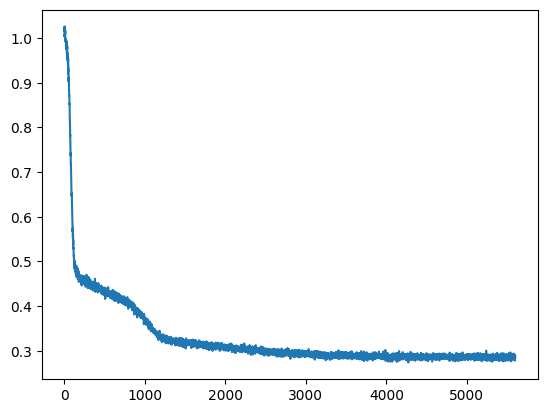

In [ ]:
plt.plot(losslog)

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

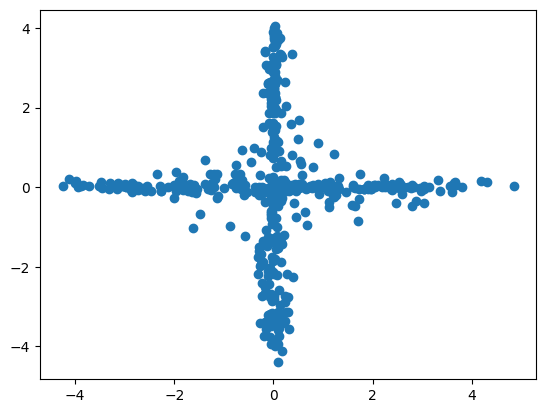

In [ ]:
generated_images = gaussian_diffusion.sample(model, batch_size=500, size=2, fast_samp=False)

temp = generated_images[-1]
plt.scatter(x=temp[:,0,0], y=temp[:,0,1])
# plt.scatter([i[0] for i in data], [i[1] for i in data])
# plt.xlim((-10,10))
# plt.ylim((-10,10));

sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

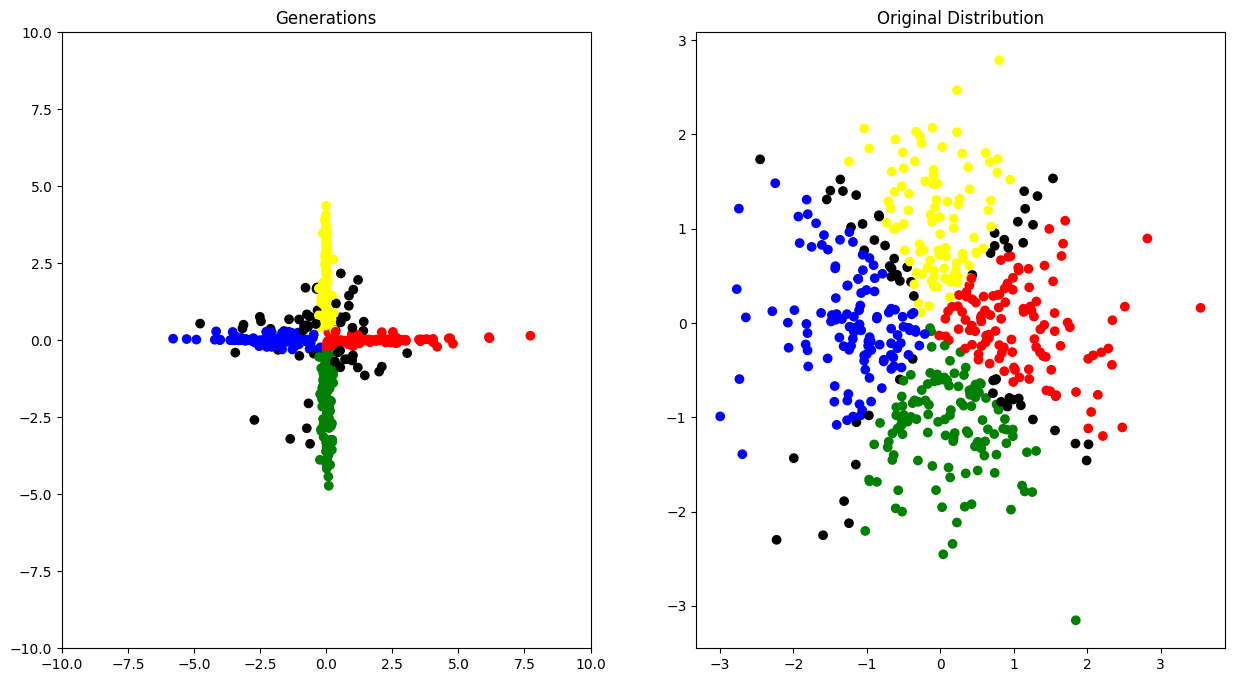

In [ ]:
def color(x, y) : 
    if abs(y)<0.3 and x>0 : return 'red'
    if abs(y)<0.3 and x<0 : return 'blue'
    if abs(x)<0.3 and y>0 : return 'yellow'
    if abs(x)<0.3 and y<0 : return 'green'
    return 'black'
    
 
original_points, creations = gaussian_diffusion.ddim_sample(model, batch_size=500, size=2)
original_points = original_points.squeeze().cpu()
creations = creations.squeeze()
colors = [color(x,y) for (x,y) in creations]

plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.title('Generations')
plt.scatter(x=[i[0] for i in creations], y=[i[1] for i in creations], c=colors)
# plt.scatter([i[0] for i in data], [i[1] for i in data], c='green', marker='.')
plt.xlim(-10,10)
plt.ylim(-10,10);
plt.subplot(1,2,2)
plt.title('Original Distribution')
plt.scatter(x=[i[0] for i in original_points], y=[i[1] for i in original_points], c=colors)

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

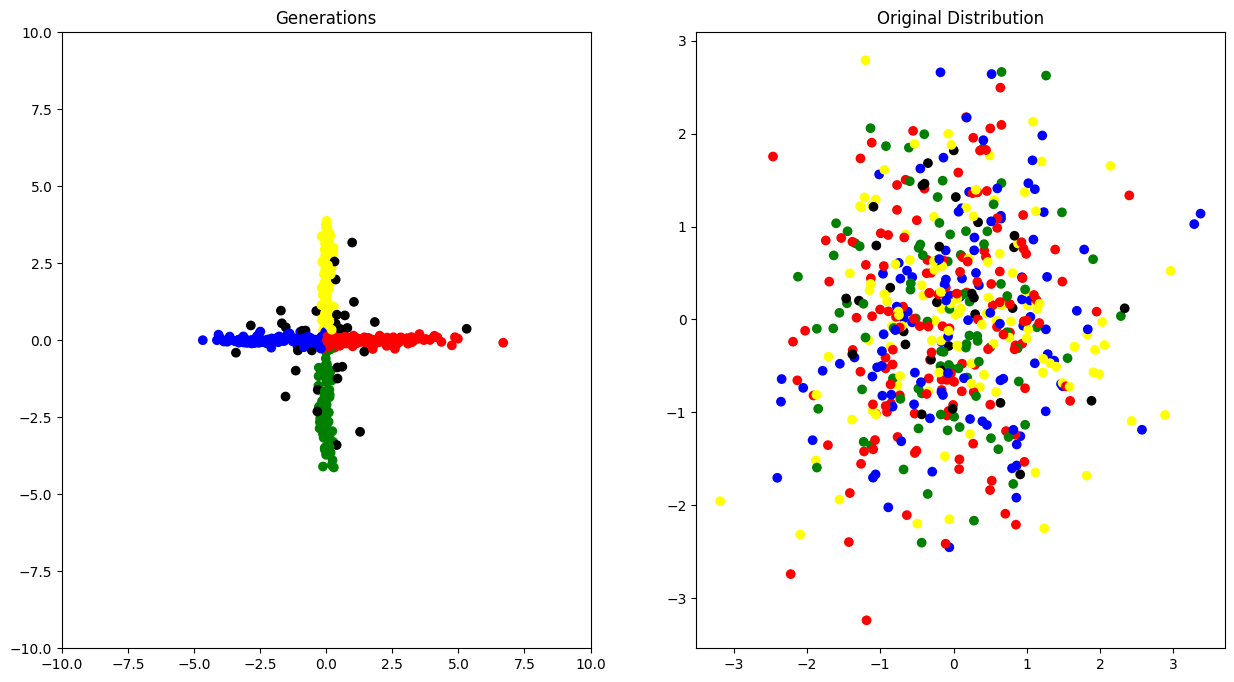

In [ ]:
def color(x, y) : 
    if abs(y)<0.3 and x>0 : return 'red'
    if abs(y)<0.3 and x<0 : return 'blue'
    if abs(x)<0.3 and y>0 : return 'yellow'
    if abs(x)<0.3 and y<0 : return 'green'
    return 'black'
    
 
generated_images = gaussian_diffusion.sample(model, batch_size=500, size=2)
original_points = generated_images[0].squeeze()
creations = generated_images[-1].squeeze()
colors = [color(x,y) for (x,y) in creations]

plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.title('Generations')
plt.scatter(x=[i[0] for i in creations], y=[i[1] for i in creations], c=colors)
# plt.scatter([i[0] for i in data], [i[1] for i in data], c='green', marker='.')
plt.xlim(-10,10)
plt.ylim(-10,10);
plt.subplot(1,2,2)
plt.title('Original Distribution')
plt.scatter(x=[i[0] for i in original_points], y=[i[1] for i in original_points], c=colors)

In [ ]:
# with fewer time steps
timesteps = 50
# define model and diffusion
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f'{device=}')
model = fwdNet(2, dim_time=4)
model.to(device)

gaussian_diffusion_50 = GaussianDiffusion(timesteps=timesteps)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# train
epochs = 4000
losslog = []

for epoch in tqdm(range(epochs)):
    for step, (points) in enumerate(train_loader):
        
        batch_size = points.shape[0]
        points = points.to(device)
        
        # sample t uniformally for every example in the batch
        t = torch.randint(0, timesteps, (batch_size,), device=device).long()
        
        loss = gaussian_diffusion_50.train_losses(model, points, t)
        with torch.no_grad() : losslog.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if epoch%300==0 : 
        tqdm.write(f"Epoch {epoch} Step {step} Loss: {loss.item()}")
    # if epoch==2000 : 
    #     optimizer.param_groups[0]['lr'] /= 10

optimizer.param_groups[0]['lr'] /= 10
for epoch in tqdm(range(1600)):
    for step, (points) in enumerate(train_loader):
        
        batch_size = points.shape[0]
        points = points.to(device)
        
        # sample t uniformally for every example in the batch
        t = torch.randint(0, timesteps, (batch_size,), device=device).long()
        
        loss = gaussian_diffusion_50.train_losses(model, points, t)
        with torch.no_grad() : losslog.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if epoch%300==0 : 
        tqdm.write(f"Epoch {epoch} Step {step} Loss: {loss.item()}")


plt.plot(losslog); plt.show()

generated_images = gaussian_diffusion_50.sample(model, batch_size=500, size=2)
original_points = generated_images[0].squeeze()
creations = generated_images[-1].squeeze()
colors = [color(x,y) for (x,y) in creations]

plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.title('Generations')
plt.scatter(x=[i[0] for i in creations], y=[i[1] for i in creations], c=colors)
# plt.scatter([i[0] for i in data], [i[1] for i in data], c='green', marker='.')
plt.xlim(-10,10)
plt.ylim(-10,10)
plt.subplot(1,2,2)
plt.title('Original Distribution')
plt.scatter(x=[i[0] for i in original_points], y=[i[1] for i in original_points], c=colors)

device='cuda:0'


  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch 0 Step 0 Loss: 1.0262197256088257
Epoch 300 Step 0 Loss: 0.46410056948661804
Epoch 600 Step 0 Loss: 0.4281028211116791
Epoch 900 Step 0 Loss: 0.4164917767047882
Epoch 1200 Step 0 Loss: 0.412418395280838
